In [1]:
import numpy as np
import swift_scrape
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]

### Extracting and Plotting Curves


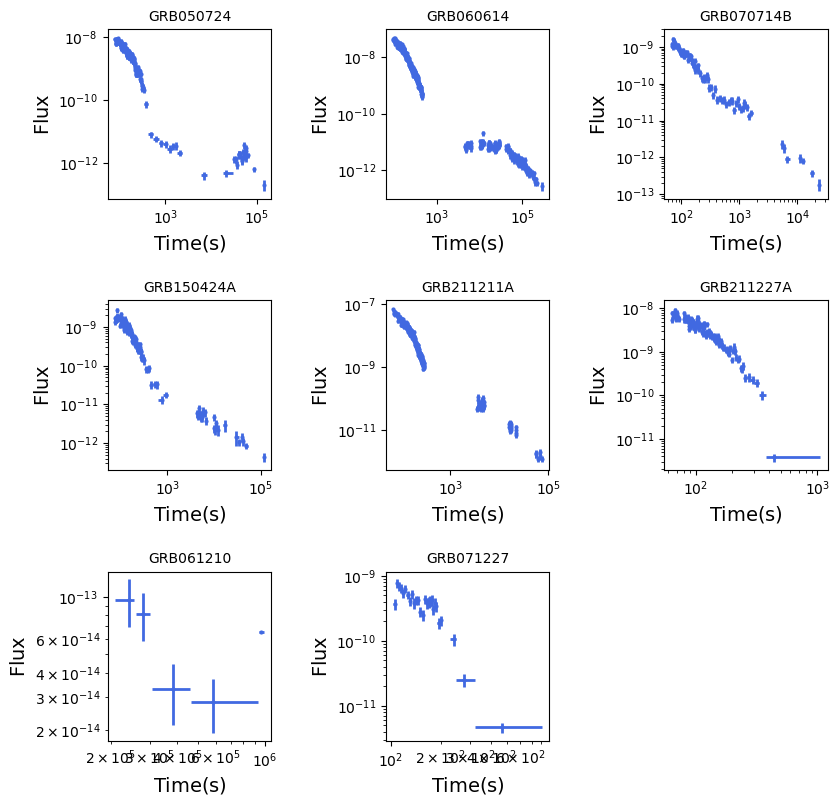

In [3]:

fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(3, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=1

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 40
    # data points      = 136
    # variables        = 4
    chi-square         = 26.2155675
    reduced chi-square = 0.19860278
    Akaike info crit   = -215.897000
    Bayesian info crit = -204.246381
[[Variables]]
    t_break:    38086.7626 +/- 1768.04324 (4.64%) (init = 20000)
    alpha_1:    0.03424605 +/- 0.04304754 (125.70%) (init = -0.2)
    alpha_2:    1.55201513 +/- 0.04952766 (3.19%) (init = 1.4)
    amplitude:  7.0672e-12 +/- 3.4909e-13 (4.94%) (init = 8.8e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = -0.8605
    C(t_break, amplitude) = -0.7023
    C(t_break, alpha_2)   = +0.6335
    C(t_break, alpha_1)   = +0.5900


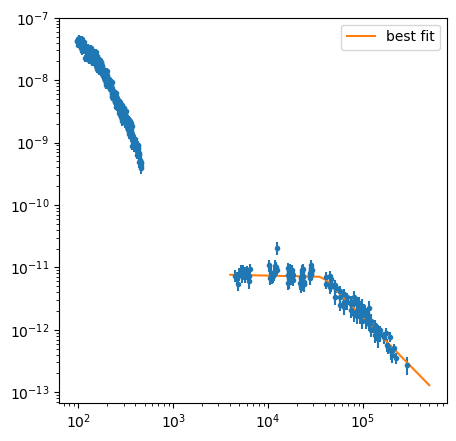

name,value,standard error,relative error,initial value,min,max,vary
t_break,38086.7626,1768.04324,(4.64%),20000.0,10000.0000,100000.000,True
alpha_1,0.03424605,0.04304754,(125.70%),-0.2,-100.000000,100.000000,True
alpha_2,1.55201513,0.04952766,(3.19%),1.4,-100.000000,100.000000,True
amplitude,7.0672e-12,3.4909e-13,(4.94%),8.8e-12,1.0000e-12,1.0000e-10,True


In [13]:
i=1
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 358
params=lm.Parameters()
params.add("t_break", min = 1e4, max = 1e5, value = 2e4)
params.add("alpha_1", min = -100, max = 100, value = -0.2)
params.add("alpha_2", min = -100, max = 100, value = 1.4)
params.add("amplitude", min = 1e-12, max = 1e-10, value = 8.8e-12)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)


bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

x1=np.geomspace(4e3,5e5,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
plt.yscale("log")
plt.xscale("log")
#plt.xlim(1e3,1e5)
plt.legend()
plt.show()

bfit

In [5]:
res_refined = lm.minimize(cost_func_bpl, method='emcee', burn=1000, steps=50000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)

res_refined.params.valuesdict()

100%|██████████| 50000/50000 [03:26<00:00, 242.60it/s]


{'t_break': 38314.864810957064,
 'alpha_1': 0.03739705042320928,
 'alpha_2': 1.5592197147667997,
 'amplitude': 7.008024284358385e-12}

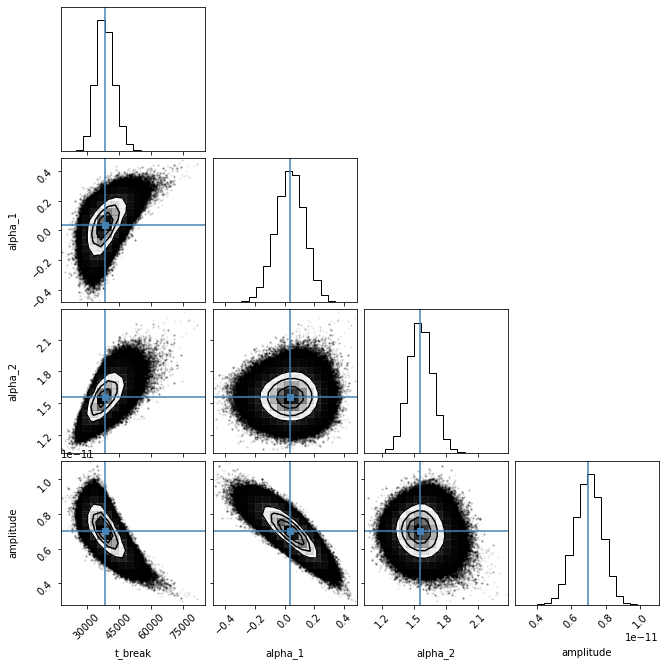

In [6]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))


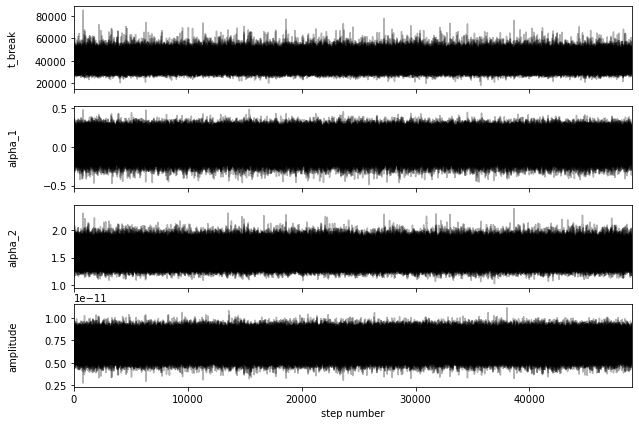

In [7]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = res_refined.chain
labels=res_refined.var_names
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Initial Emission

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 16
    # data points      = 357
    # variables        = 2
    chi-square         = 233.228406
    reduced chi-square = 0.65698143
    Akaike info crit   = -147.981156
    Bayesian info crit = -140.225685
[[Variables]]
    alpha_1:    2.81899524 +/- 0.02492652 (0.88%) (init = 3)
    amplitude:  0.02424182 +/- 0.00327281 (13.50%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = 0.996


<Figure size 800x800 with 0 Axes>

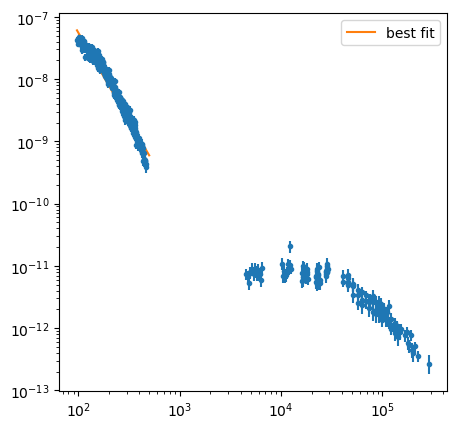

name,value,standard error,relative error,initial value,min,max,vary
alpha_1,2.81899524,0.02492652,(0.88%),3.0,0.00000000,10.0000000,True
amplitude,0.02424182,0.00327281,(13.50%),0.0001,1.0000e-04,10.0000000,True


In [8]:
i=1
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 357
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 3.0)
params_ini.add("amplitude", min = 1e-4, max = 10, value = 3e-5)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="least_squares")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(97,500,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
# plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
# plt.plot(x1,power_law(x1, 3, 9e-2),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

bfit_ini

In [9]:
res_refined_ini = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=50000,
                            params=bfit_ini, is_weighted=True, args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]),nwalkers = 100)

100%|██████████| 50000/50000 [03:35<00:00, 232.34it/s]


{'alpha_1': 2.8232483527234455, 'amplitude': 0.024801719303824438}

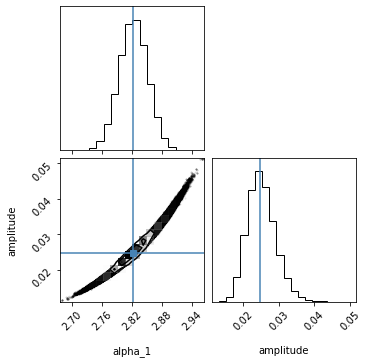

In [10]:
emcee_plot = corner.corner(res_refined_ini.flatchain, labels=res_refined_ini.var_names,
                           truths=list((res_refined_ini.params.valuesdict().values())))

res_refined_ini.params.valuesdict()

In [11]:
df = pd.read_csv("grb_bpl.csv")
pd_row = res_refined.params.valuesdict()
pd_row["GRB Name"] = GRBs[i]
pd_row["GRB Index"] = i
df.iloc[i] = pd_row
df.to_csv("grb_bpl.csv",index=False)

df2 = pd.read_csv("grb_initial_pl.csv")
pd_row2 = res_refined_ini.params.valuesdict()
pd_row2["GRB Name"] = GRBs[i]
pd_row2["GRB Index"] = i
df2.iloc[i] = pd_row2
df2.to_csv("grb_initial_pl.csv",index=False)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 494
    # variables        = 6
    chi-square         = 259.446922
    reduced chi-square = 0.53165353
    Akaike info crit   = -306.127788
    Bayesian info crit = -280.912575
[[Variables]]
    tb0:        2334.66952 +/- 117.539263 (5.03%) (init = 1000)
    tb1:        38064.1562 +/- 2872.16146 (7.55%) (init = 20000)
    alpha_0:    2.81899278 +/- 0.02242329 (0.80%) (init = 4)
    alpha_1:    0.03292076 +/- 0.06813725 (206.97%) (init = -0.2)
    alpha_2:    1.55201462 +/- 0.08103441 (5.22%) (init = 1.4)
    amplitude:  7.7545e-12 +/- 1.0157e-12 (13.10%) (init = 8.8e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = 0.951
    C(tb0, amplitude)     = -0.925
    C(tb0, alpha_1)       = -0.878
    C(tb1, alpha_2)       = 0.638
    C(tb1, alpha_1)       = 0.585
    C(tb1, amplitude)     = 0.449
    C(tb0, tb1)           = -0.415
    C(tb0, alph

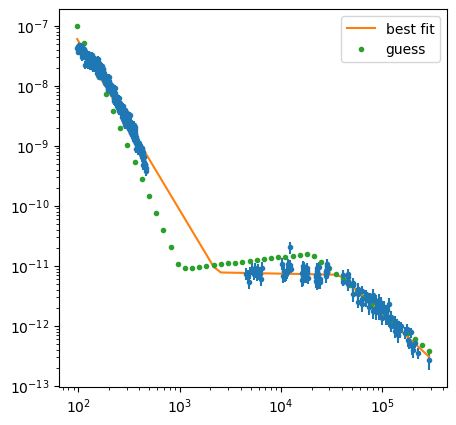

name,value,standard error,relative error,initial value,min,max,vary
tb0,2334.66952,117.539263,(5.03%),1000.0,500.000000,5000.00000,True
tb1,38064.1562,2872.16146,(7.55%),20000.0,10000.0000,100000.000,True
alpha_0,2.81899278,0.02242329,(0.80%),4.0,0.00000000,10.0000000,True
alpha_1,0.03292076,0.06813725,(206.97%),-0.2,-100.000000,100.000000,True
alpha_2,1.55201462,0.08103441,(5.22%),1.4,-100.000000,100.000000,True
amplitude,7.7545e-12,1.0157e-12,(13.10%),8.8e-12,1.0000e-12,1.0000e-10,True


In [12]:
params_dbpl=lm.Parameters()
params_dbpl.add("tb0", min = 5e2, max = 5e3, value = 1e3)
params_dbpl.add("tb1", min = 1e4, max = 1e5, value = 2e4)
params_dbpl.add("alpha_0", min = 0, max = 10.0, value = 4.0)
params_dbpl.add("alpha_1", min = -100, max = 100, value = -0.2)
params_dbpl.add("alpha_2", min = -100, max = 100, value = 1.4)
params_dbpl.add("amplitude", min = 1e-12, max = 1e-10, value = 8.8e-12)

minner = lm.Minimizer(cost_func_nbpl, params_dbpl, fcn_args=(time, flux, time_err, flux_err, 3))
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

bfit = result.params
tb0 = bfit["tb0"].value
tb1 = bfit["tb1"].value
alp0 = bfit["alpha_0"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

x = np.geomspace(time[0],time[-1])
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x,double_broken_law(x,tb0, tb1, alp0, alp1, alp2, amp),label ='best fit')
plt.plot(x,double_broken_law(x,1e3, 2e4, 4.0, -0.2, 1.4, 8.8e-12),'.',label ='guess')
plt.yscale("log")
plt.xscale("log")
#plt.xlim(1e3,1e5)
plt.legend()
plt.show()

bfit

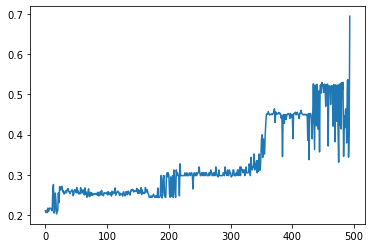

In [13]:
plt.plot(flux_err/flux)

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 150
    # data points      = 494
    # variables        = 8
    chi-square         = 119.433534
    reduced chi-square = 0.24574801
    Akaike info crit   = -685.369098
    Bayesian info crit = -651.748813
[[Variables]]
    tb0:        179.204968 +/- 3.10087470 (1.73%) (init = 150)
    tb1:        1631.78143 +/- 58.5172455 (3.59%) (init = 1300)
    tb2:        38064.1740 +/- 1953.00938 (5.13%) (init = 20000)
    alpha_0:    1.74842875 +/- 0.06622848 (3.79%) (init = 1)
    alpha_1:    3.41665701 +/- 0.03517125 (1.03%) (init = 4)
    alpha_2:    0.03305444 +/- 0.04632017 (140.13%) (init = -0.2)
    alpha_3:    1.55194687 +/- 0.05509445 (3.55%) (init = 1.4)
    amplitude:  1.4875e-08 +/- 7.4376e-10 (5.00%) (init = 3e-08)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.9597
    C(tb1, alpha_2)       = -0.8267
    C(alpha_0, amplitude) = -0.7724
    C(tb0, alpha_0)       

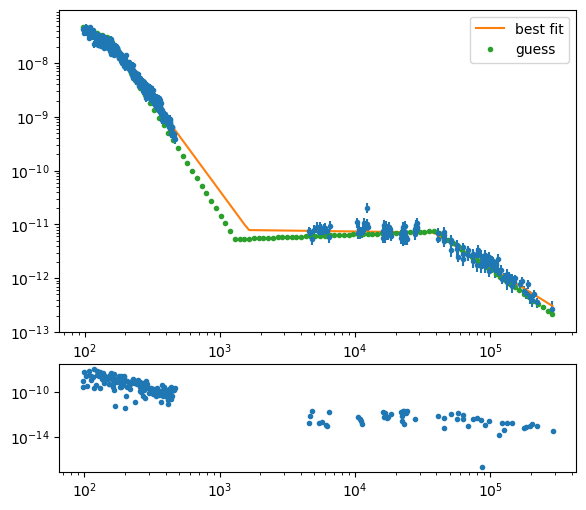

name,value,standard error,relative error,initial value,min,max,vary
tb0,179.204968,3.10087470,(1.73%),150.0,100.000000,300.000000,True
tb1,1631.78143,58.5172455,(3.59%),1300.0,500.000000,5000.00000,True
tb2,38064.1740,1953.00938,(5.13%),20000.0,10000.0000,100000.000,True
alpha_0,1.74842875,0.06622848,(3.79%),1.0,-10.0000000,10.0000000,True
alpha_1,3.41665701,0.03517125,(1.03%),4.0,-10.0000000,10.0000000,True
alpha_2,0.03305444,0.04632017,(140.13%),-0.2,-100.000000,100.000000,True
alpha_3,1.55194687,0.05509445,(3.55%),1.4,-100.000000,100.000000,True
amplitude,1.4875e-08,7.4376e-10,(5.00%),3e-08,1.0000e-08,1.0000e-07,True


In [10]:
i=1
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=4
params=lm.Parameters()
params.add("tb0", min = 1e2, max = 3e2, value = 1.5e2)
params.add("tb1", min = 5e2, max = 5e3, value = 1.3e3)
params.add("tb2", min = 1e4, max = 1e5, value = 2e4)
params.add("alpha_0", min = -10, max = 10.0, value = 1.0)
params.add("alpha_1", min = -10, max = 10.0, value = 4.0)
params.add("alpha_2", min = -100, max = 100, value = -0.2)
params.add("alpha_3", min = -100, max = 100, value = 1.4)
params.add("amplitude", min = 1e-8, max = 1e-7, value = 3e-8)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
ax1.loglog(x, nbroken_law(x, [1.5e2, 1.3e3, 4e4], [1, 4.0, -0.1, 1.8], 3e-8),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.15)
plt.show()


result.params